In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'construction-site-safety-image-dataset-roboflow:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2919095%2F5048288%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T073620Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2c0221b40957213e6383407b7669683097824c87864a1fad76ec2721eb1b194446a94566799ad9aab4debd9d3c98a74f244c69428e675a115a6d38e34c69b6756bd07cae9e43a20683e76c35e286321639cdb354862dfb0a762e6d5ef30f2ef504524fb72be09d48491e38a9f0ee09d1f7af8ab331532157244101a653bea0206b4a93e9f75e1909bc80a7ab5bb445816d098065c9bbc5bb1a0b87c36e420c1fe0d0e15cf714e6b4eebd5c5cf5545d5d17f9ad3a592f5b78d06c496e6172e9bfa8bc968c97aff155ebe04ec741a441e351424393ff2b73c4086a65bab9366d39c4928a7022a44f53ddb451df1d40a922f17dabe37386431c2e744fbcb683dea8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 216024261 bytes downloaded
Downloaded and uncompressed: construction-site-safety-image-dataset-roboflow
Data source import complete.


In [ ]:
import os

def filter_and_rename_labels(input_dir, classes_to_remove, class_to_rename_map):
    print(f"Processing directory: {input_dir}")
    processed_files = 0
    for filename in os.listdir(input_dir):
        if filename.endswith(".txt"):  # Target label files
            file_path = os.path.join(input_dir, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()

            new_lines = []
            for line in lines:
                class_id, *coords = line.strip().split()
                class_id = int(class_id)

                # Remove unwanted classes
                if class_id in classes_to_remove:
                    continue

                # Rename specified classes to new class indices
                if class_id in class_to_rename_map:
                    class_id = class_to_rename_map[class_id]

                new_line = f"{class_id} {' '.join(coords)}\n"
                new_lines.append(new_line)

            # Write the filtered and updated lines back to the same file, overwriting it
            with open(file_path, 'w') as file:
                file.writelines(new_lines)

            processed_files += 1

    print(f"Processed {processed_files} files in {input_dir}")

# Directories to process
directories = [
    '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels',
    '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels',
    '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/labels'
]

classes_to_remove = {1, 3, 4, 6, 7, 8, 9}  # Class IDs for Mask, NO-Mask, NO-Safety Vest, Safety Cone, Safety Vest, Machinery, and Vehicle
class_to_rename_map = {2: 1, 5: 2}  # Mapping of class IDs to new IDs

# Process each directory
for dir_path in directories:
    filter_and_rename_labels(dir_path, classes_to_remove, class_to_rename_map)

Processing directory: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels
Processed 2605 files in /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels
Processing directory: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels
Processed 114 files in /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels
Processing directory: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/labels
Processed 82 files in /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/labels


In [ ]:
import os

def check_and_remove_empty_annotations(label_dir, image_dir):
    empty_files = []
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            label_path = os.path.join(label_dir, filename)
            with open(label_path, 'r') as file:
                lines = file.readlines()
                if len(lines) == 0:
                    empty_files.append(filename)
                    os.remove(label_path)  # Remove the empty annotation file
                    # Remove the corresponding image file
                    image_filename = filename.replace('.txt', '.jpg')  # Assuming images are in .jpg format
                    image_path = os.path.join(image_dir, image_filename)
                    if os.path.exists(image_path):
                        os.remove(image_path)
                    else:
                        print(f"Image file {image_path} not found.")
    return empty_files

# Directories for training and validation annotations and images
train_labels_dir = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels'
train_images_dir = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images'
validation_labels_dir = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels'
validation_images_dir = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/images'
test_labels_dir = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/labels'
test_images_dir = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images'

# Check and remove empty annotation files for training set
empty_train_files = check_and_remove_empty_annotations(train_labels_dir, train_images_dir)
if empty_train_files:
    print(f"Found and removed {len(empty_train_files)} empty annotation files in the training set:")
    for file in empty_train_files:
        print(file)
else:
    print("No empty annotation files found in the training set.")

# Check and remove empty annotation files for validation set
empty_val_files = check_and_remove_empty_annotations(validation_labels_dir, validation_images_dir)
if empty_val_files:
    print(f"Found and removed {len(empty_val_files)} empty annotation files in the validation set:")
    for file in empty_val_files:
        print(file)
else:
    print("No empty annotation files found in the validation set.")

# Check and remove empty annotation files for testing set
empty_test_files = check_and_remove_empty_annotations(test_labels_dir, test_images_dir)
if empty_test_files:
    print(f"Found and removed {len(empty_test_files)} empty annotation files in the testing set:")
    for file in empty_test_files:
        print(file)
else:
    print("No empty annotation files found in the testing set.")

Found and removed 70 empty annotation files in the training set:
youtube-196_jpg.rf.d9d5913fb05f3dfcc17d19e54e9ecbf6.txt
construction-5-_mp4-30_jpg.rf.f671ac8915234f2ca8b9246d095055e9.txt
airport_inside_0550_jpg.rf.d35ed2eaed77cca9c93f3d7c31064003.txt
youtube-230_jpg.rf.462aca78b71bedb66bce8aeef766a9af.txt
image_880_jpg.rf.9fc48cdadc429034a5868be1d6ca6f5a.txt
youtube-855_jpg.rf.346f539ebe7317c5c7202185ddd56af5.txt
construction-986-_jpg.rf.3ecb527ce78e89716a17826e5d05f682.txt
autox5_mp4-34_jpg.rf.e0c7d0632b6b6ec9aae7b89a2b096bea.txt
construction-619-_jpg.rf.a59235e60c4da86f5647c8b8bd506ebd.txt
165_jpg.rf.c64f254d162c3ae612e21e5f8ab4962c.txt
n457047_jpg.rf.a714b0b010973b624497d7a67f4c8816.txt
youtube-18_jpg.rf.f881a0e8125381315c9391d4f03a13da.txt
image_55_jpg.rf.4f4acd932047860fa58ac1e9e5c91c46.txt
image_288_jpg.rf.b1293d82f4892b97d0592ad08d205650.txt
construction-1050-_jpg.rf.6906df9b82b1cfb9a06fe3fa8aa1ad3f.txt
youtube-667_jpg.rf.d2f2249f002ec216499a1284b54abb00.txt
construction-212-_j

# About

- In this notebook I will train Yolo v9 model to detect PPE (Personal Protective Equipment), using [this existing dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow) from [Roboflow](https://universe.roboflow.com/)
- In the [next notebook](https://www.kaggle.com/hinepo/yolov9-inference-for-red-zone-application) I will use this custom model to make inference on videos and post-process the results so they can be used in a Red Zone/Trespassing detection application
- This notebook is a generic training pipeline that you can use to train any Yolo model for object detection task on any dataset (images/number of classes), as long as you provide the dataset in the correct folder structure accepted by Yolo and the annotations/labels in Yolo format
- [Ultralytics - docs](https://docs.ultralytics.com/)
- [Ultralytics - github](https://github.com/ultralytics/ultralytics)

___

[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

**<font color='orange'>If you like this notebook, don't forget to show your support with your upvote!</font>**

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e87b8a1c-57ed-d582-99a6-98737f4ae0c8)


# Installs/Imports

In [ ]:
%%time

! pip install --upgrade ultralytics -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 27.0 MB/s eta 0:00:00
CPU times: user 29.4 ms, sys: 3.6 ms, total: 33 ms
Wall time: 4.12 s


In [ ]:
import ultralytics
print(ultralytics.__version__)

8.2.86


In [ ]:
!pip install wandb

import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'NO-Hardhat', 'Person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'Adam' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto (DEFAULT)
    LR = 5e-5 # LR = 1e-4
    LR_FACTOR = 0.1 # LR_FACTOR = 0.01
    WEIGHT_DECAY = 1e-4 # WEIGHT_DECAY = 5e-3
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.1 # LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [ ]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- NO-Hardhat
- Person
nc: 3
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



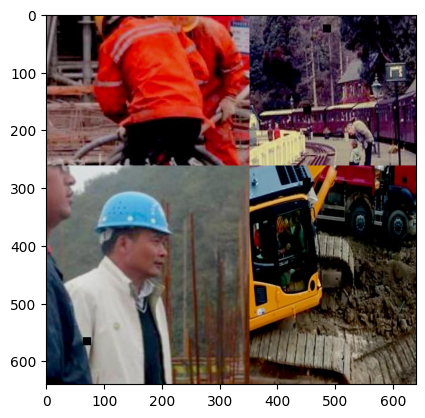

In [ ]:
example_image_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

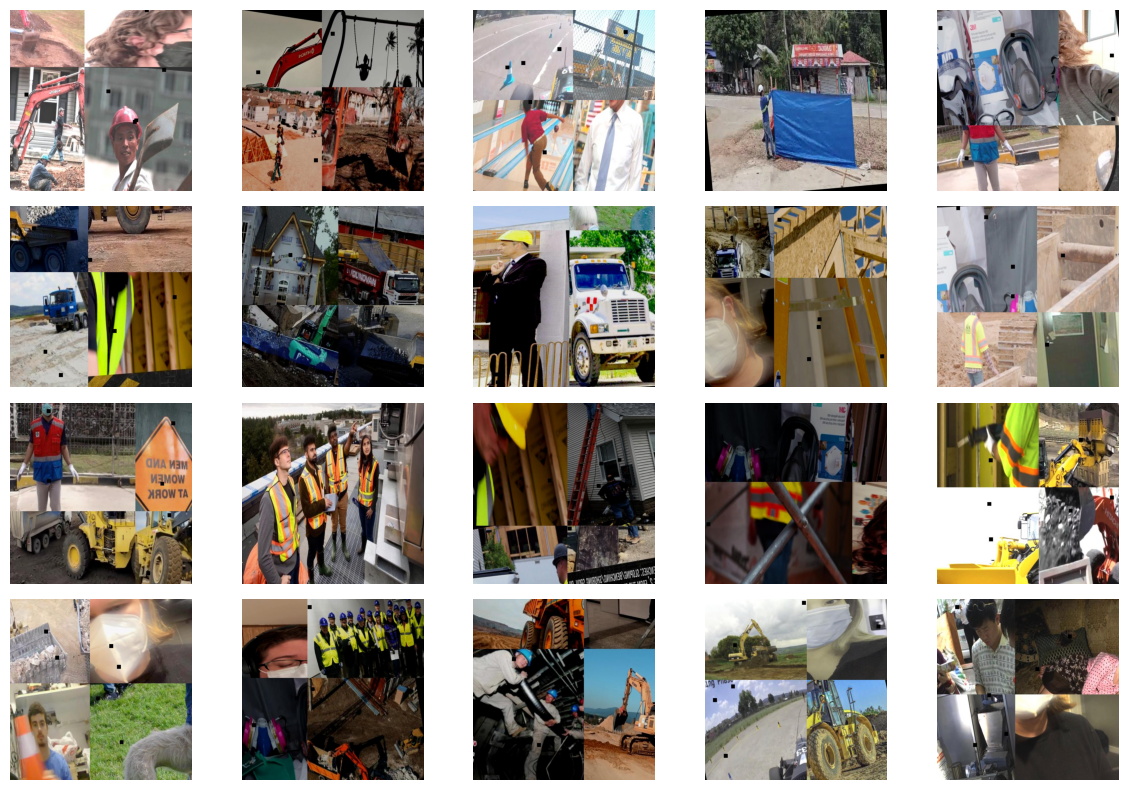

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [ ]:
%%time
import os

# Creating index only for existing classes
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

# Helper set to quickly check valid classes
valid_classes = set(class_idx.keys())

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}
    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

        # Collecting unique valid class indices from the file
        valid_indices = set(line.strip().split()[0] for line in lines if line.strip().split()[0] in valid_classes)

        # Increment class counts based on valid class indices found
        for cls in valid_indices:
            class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 93.8 ms, sys: 36.6 ms, total: 130 ms
Wall time: 139 ms


,Mode,Hardhat,NO-Hardhat,Person,Data_Volume
0,train,1473,1440,2703,2712
1,valid,57,44,101,101
2,test,36,28,67,68


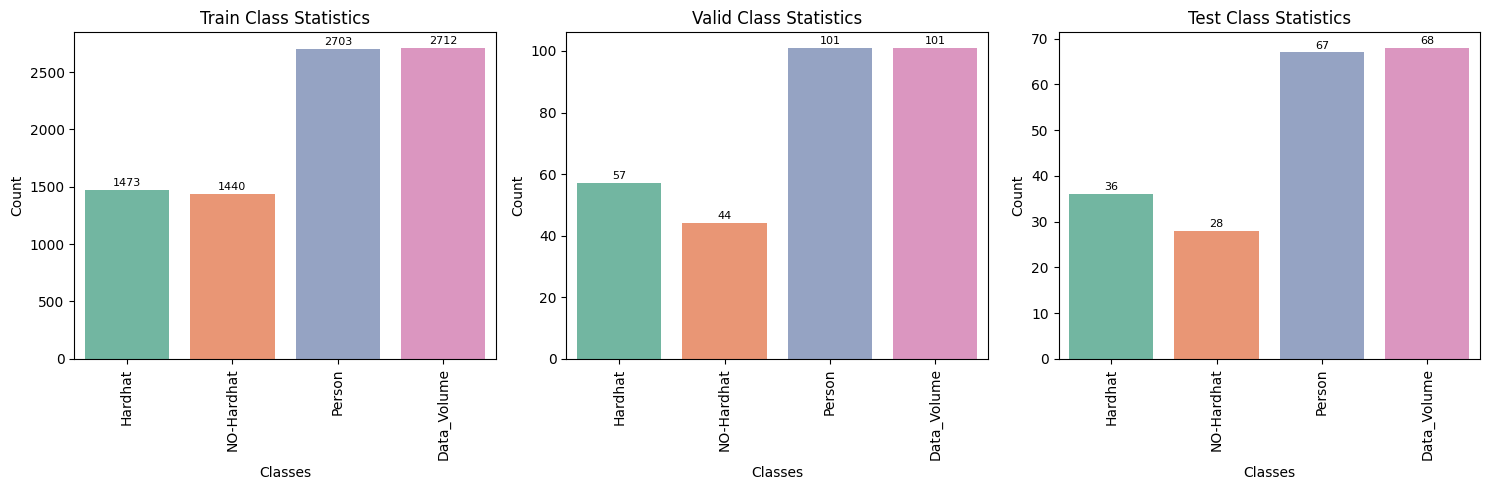

In [ ]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 281 ms, sys: 42.5 ms, total: 324 ms
Wall time: 345 ms


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = 0,  # Adjusted for a single GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

import torch
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

100%|██████████| 112M/112M [00:00<00:00, 131MB/s]



image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 90.4ms
Speed: 9.8ms preprocess, 90.4ms inference, 788.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
CUDA Available: True
Number of GPUs: 1


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



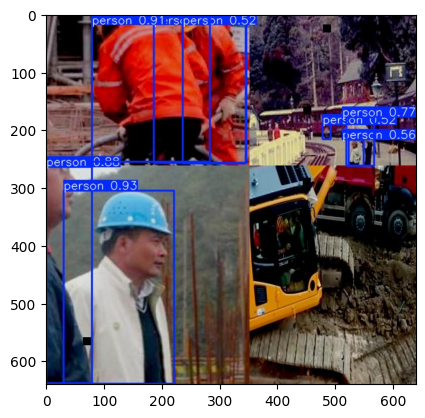

In [ ]:
### check predictions with base model
# Move directory from content to kaggle in order for this to work
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/kaggle/working/runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  16


In [ ]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
import os
import zipfile

# Define the directory to be zipped and the output zip file name
directory_to_zip = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data'
output_zip_file = '/kaggle/emptytestnonormalize.zip'

# Create a ZipFile object
with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(directory_to_zip):
        for filename in filenames:
            # Create a complete path of file to be zipped
            file_to_zip = os.path.join(dirpath, filename)
            # Adding file to zip
            zipf.write(file_to_zip, arcname=os.path.relpath(file_to_zip, directory_to_zip))

print("Files zipped successfully!")

Files zipped successfully!


In [ ]:
%%time

### Reduce batch size and possibly adjust image size
reduced_batch_size = CFG.BATCH_SIZE // 2  # Example: reduce batch size by half
reduced_image_size = (img_properties['height'] // 2, img_properties['width'] // 2)  # Example: reduce image dimensions by half

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = reduced_image_size,  # Use reduced image size if necessary

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=70, time=None, patience=20, batch=16, imgsz=(320, 320), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


WARNING ⚠️ YOLOv9 `Silence` module is deprecated in favor of nn.Identity. Please delete local *.pt file and re-download the latest model checkpoint.
Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6           

100%|██████████| 6.25M/6.25M [00:00<00:00, 114MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=320'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2712 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2712/2712 [00:01<00:00, 1986.75it/s]


train: New cache created: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<00:00, 1264.50it/s]

val: New cache created: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels.cache


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: Adam(lr=5e-05, momentum=0.937) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0001), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      7.63G      1.194      1.424      1.311         35        320: 100%|██████████| 170/170 [01:37<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        101        426      0.571      0.306       0.33      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      6.71G      1.069      1.024       1.21         75        320: 100%|██████████| 170/170 [01:29<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        101        426      0.885      0.681      0.755       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      6.81G      1.021     0.9151       1.19         51        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.863       0.68      0.737      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      6.69G     0.9928     0.8517       1.16         59        320: 100%|██████████| 170/170 [01:25<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        101        426      0.872      0.719      0.789      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70       6.8G     0.9418     0.7882      1.141         97        320: 100%|██████████| 170/170 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        101        426      0.866      0.725      0.795      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      6.68G     0.9188     0.7639      1.128         64        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        101        426      0.859      0.718      0.791      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      6.79G     0.8903     0.7279      1.113         55        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        101        426      0.856      0.704      0.756      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      6.67G     0.8894     0.7012      1.103         56        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        101        426      0.878      0.715      0.771      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      6.79G     0.8696      0.686      1.098         65        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.917      0.699      0.782      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      6.68G     0.8513     0.6727      1.093         61        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        101        426       0.89      0.697       0.79      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      6.79G     0.8382     0.6404      1.083         99        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.862      0.729      0.791      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      6.69G     0.8389      0.635      1.081         66        320: 100%|██████████| 170/170 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.909      0.747        0.8      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70       6.8G     0.8203     0.6207      1.076         79        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        101        426      0.919      0.743      0.812      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      6.67G     0.8202     0.6116      1.077         82        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        101        426      0.891      0.739      0.803      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      6.79G     0.7989     0.5936      1.065         89        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        101        426      0.908      0.733      0.802      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      6.69G     0.7817     0.5787      1.056         61        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        101        426      0.922      0.751      0.812      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      6.79G     0.7747     0.5681      1.051         65        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        101        426      0.901      0.732      0.819      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      6.69G     0.7691     0.5713      1.052         78        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        101        426      0.894      0.752      0.817      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      6.79G     0.7626     0.5573      1.044         49        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        101        426      0.948      0.729      0.831      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      6.69G     0.7573     0.5476       1.04         61        320: 100%|██████████| 170/170 [01:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        101        426      0.946      0.754      0.827      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      6.79G     0.7511     0.5414      1.039         73        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        101        426      0.926      0.747      0.842       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      6.67G     0.7344     0.5321      1.034         73        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        101        426      0.917      0.752      0.835      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      6.79G     0.7328     0.5147      1.031         67        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        101        426      0.949      0.766      0.833      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70       6.7G     0.7275     0.5198      1.033         95        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        101        426      0.884      0.762      0.827       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      6.78G     0.7168     0.5133      1.029        107        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        101        426      0.908      0.753       0.83      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      6.69G     0.7133      0.512      1.022         47        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.911       0.79       0.84      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70       6.8G     0.7083     0.5007      1.018         64        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        101        426      0.906      0.762      0.827       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70       6.7G     0.6991     0.4956       1.01         65        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        101        426      0.906       0.79      0.845      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      6.79G      0.698     0.4849       1.01         97        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        101        426      0.939      0.785      0.852       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      6.67G     0.6847     0.4857      1.008        106        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        101        426      0.927      0.776      0.851      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      6.79G     0.6793     0.4692      1.006         68        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        101        426       0.94      0.754       0.85      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      6.68G     0.6899     0.4715      1.013        148        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        101        426      0.951      0.756      0.845      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      6.79G     0.6709     0.4651     0.9979         86        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        101        426      0.949       0.77      0.848      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      6.68G      0.662     0.4618     0.9989         79        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        101        426      0.942      0.752      0.844       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      6.79G     0.6657       0.46     0.9975        105        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        101        426      0.929      0.805      0.857      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      6.66G      0.659     0.4568      0.991         61        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        101        426      0.946       0.76      0.855      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70       6.8G     0.6465     0.4479     0.9889         83        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.927      0.782      0.853      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      6.69G     0.6545     0.4446     0.9825         35        320: 100%|██████████| 170/170 [01:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        101        426       0.93      0.781      0.852      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70       6.8G     0.6394     0.4346     0.9875         62        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        101        426      0.899      0.797      0.847      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      6.66G       0.63     0.4324     0.9817        112        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        101        426      0.905      0.814      0.862      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      6.79G     0.6313     0.4286     0.9804         35        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        101        426      0.918      0.788      0.854      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      6.69G     0.6266      0.425     0.9791         75        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        101        426      0.929      0.795      0.848      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      6.79G     0.6216     0.4254     0.9754         76        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        101        426       0.92      0.812      0.859      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      6.69G     0.6174     0.4189     0.9784         76        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.947      0.785       0.86      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      6.79G     0.6165     0.4197     0.9758         85        320: 100%|██████████| 170/170 [01:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        101        426      0.939      0.777      0.857      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      6.67G     0.6162     0.4191     0.9769         88        320: 100%|██████████| 170/170 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        101        426      0.918      0.794      0.852      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70       6.8G     0.6067     0.4166     0.9782         67        320: 100%|██████████| 170/170 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        101        426        0.9      0.804      0.858      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      6.68G     0.5986     0.4044     0.9687         72        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        101        426       0.92      0.784      0.857      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      6.79G     0.5984     0.4049     0.9644         73        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.969      0.763      0.861      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      6.68G     0.5963     0.4054     0.9595         96        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        101        426      0.924      0.797      0.864      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      6.79G     0.5968     0.4043     0.9599         59        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all        101        426      0.932      0.782      0.865       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      6.67G     0.5903      0.399     0.9559         69        320: 100%|██████████| 170/170 [01:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all        101        426      0.927      0.777      0.859      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      6.79G     0.5913     0.3893     0.9558         66        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        101        426      0.953      0.777      0.864      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      6.68G     0.5703     0.3847      0.951         72        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.895      0.801      0.856      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70       6.8G     0.5801     0.3895     0.9515         53        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        101        426      0.944      0.792      0.868      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      6.68G     0.5748     0.3825     0.9518         46        320: 100%|██████████| 170/170 [01:26<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        101        426       0.93      0.801       0.87      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      6.79G       0.56     0.3769     0.9428         52        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        101        426      0.956      0.776      0.867      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      6.68G     0.5671     0.3853     0.9526         74        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        101        426      0.931      0.795      0.863      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      6.79G     0.5594     0.3758      0.948         83        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        101        426      0.934      0.797      0.868      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      6.69G     0.5586     0.3727     0.9469         50        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        101        426       0.93      0.811      0.863      0.612


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      6.81G     0.5388     0.3094     0.9229         55        320: 100%|██████████| 170/170 [01:29<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        101        426      0.934      0.795      0.864      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      6.68G     0.5293     0.3064     0.9163         33        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.939      0.807      0.861      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      6.79G     0.5226     0.3003     0.9136         30        320: 100%|██████████| 170/170 [01:26<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        101        426      0.957      0.811      0.864      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      6.69G     0.5143     0.2938     0.9134         56        320: 100%|██████████| 170/170 [01:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        101        426      0.947       0.81      0.872      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      6.79G     0.5122     0.2943     0.9114         48        320: 100%|██████████| 170/170 [01:27<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        101        426      0.961      0.807       0.87      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      6.68G      0.507     0.2901     0.9084         40        320: 100%|██████████| 170/170 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        101        426      0.962      0.808      0.859      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      6.79G     0.5032     0.2872     0.9087         33        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        101        426      0.959      0.806      0.856      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      6.69G     0.4947     0.2852     0.9026         40        320: 100%|██████████| 170/170 [01:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        101        426      0.946      0.812      0.866      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      6.79G     0.4952     0.2836      0.906         35        320: 100%|██████████| 170/170 [01:27<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        101        426      0.961      0.805      0.862      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      6.69G     0.4886     0.2795     0.8993         38        320: 100%|██████████| 170/170 [01:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        101        426      0.963      0.792      0.867      0.606



70 epochs completed in 1.898 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.2MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.2MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9e summary (fused): 687 layers, 57,378,713 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


                   all        101        426      0.959      0.776      0.867      0.623
Speed: 0.7ms preprocess, 13.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs
CPU times: user 1h 26min 6s, sys: 12min 22s, total: 1h 38min 28s
Wall time: 1h 54min 36s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a8f5ceeef20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv9 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [ ]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv9e summary (fused): 687 layers, 57,378,713 parameters, 0 gradients, 189.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (111.8 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 300.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.5s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 19.6s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (29.7s)
Results saved to /content/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_ep

'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

# Train results

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg']

./runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


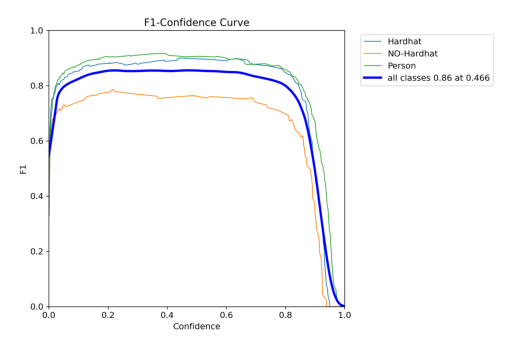



./runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


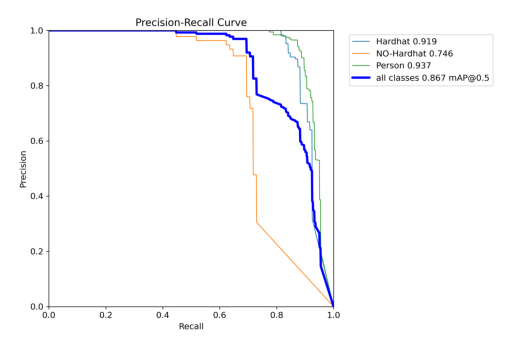



./runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


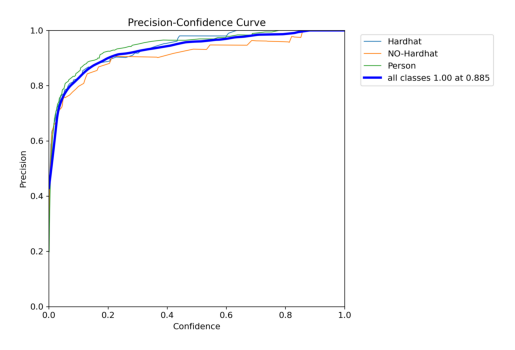



./runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


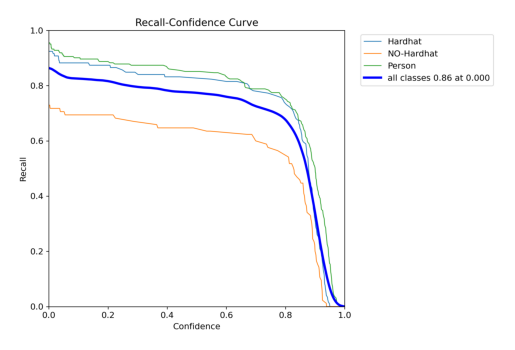



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


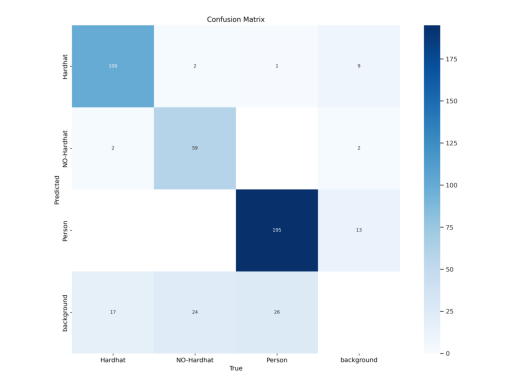



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


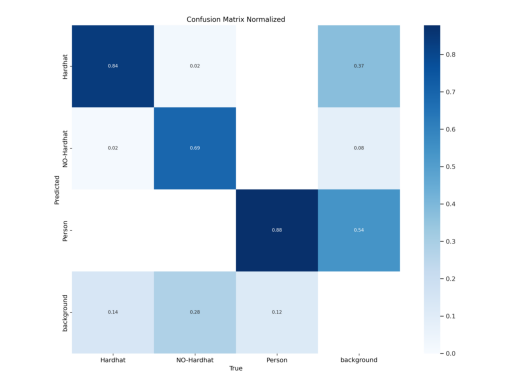



./runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


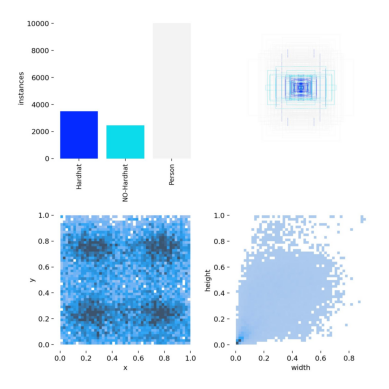



./runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


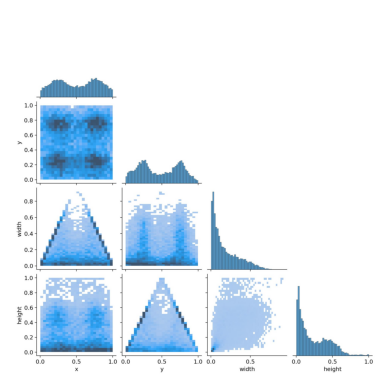



./runs/detect/yolov9e_ppe_css_70_epochs/results.png


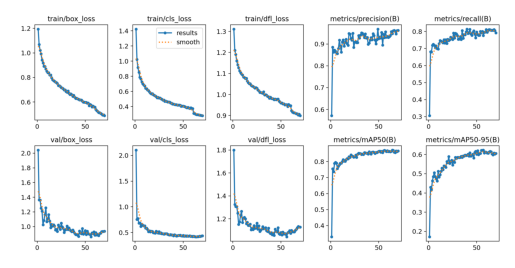

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

# Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.19440,1.42400,1.31130,0.57135,0.30581,0.33031,0.17216,2.04210,2.10430,1.7993,0.066879,0.000017,0.000017
1,2,1.06860,1.02370,1.21000,0.88537,0.68083,0.75511,0.42973,1.36370,0.75598,1.3248,0.033562,0.000033,0.000033
2,3,1.02110,0.91509,1.19010,0.86254,0.68022,0.73699,0.41661,1.36220,0.77212,1.3073,0.000245,0.000049,0.000049
3,4,0.99279,0.85172,1.16000,0.87213,0.71901,0.78872,0.46306,1.25130,0.68167,1.3067,0.000048,0.000048,0.000048
4,5,0.94177,0.78822,1.14130,0.86619,0.72493,0.79506,0.48513,1.21230,0.68548,1.2504,0.000047,0.000047,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.50696,0.29011,0.90839,0.96215,0.80806,0.85917,0.60400,0.91020,0.42077,1.1103,0.000008,0.000008,0.000008
66,67,0.50316,0.28723,0.90873,0.95866,0.80650,0.85629,0.59780,0.93036,0.42539,1.1223,0.000008,0.000008,0.000008
67,68,0.49474,0.28523,0.90264,0.94584,0.81184,0.86641,0.60744,0.93271,0.42407,1.1335,0.000007,0.000007,0.000007
68,69,0.49523,0.28362,0.90604,0.96108,0.80459,0.86247,0.60266,0.93350,0.43050,1.1285,0.000006,0.000006,0.000006


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.48858 , on epoch:  70 


Best Validation Box loss:  0.86141 , on epoch:  56 


Best Training Cls loss:  0.27945 , on epoch:  70 


Best Validation Cls loss:  0.41647 , on epoch:  63 


Best Training DFL loss:  0.89926 , on epoch:  70 


Best Validation DFL loss:  1.044 , on epoch:  56 



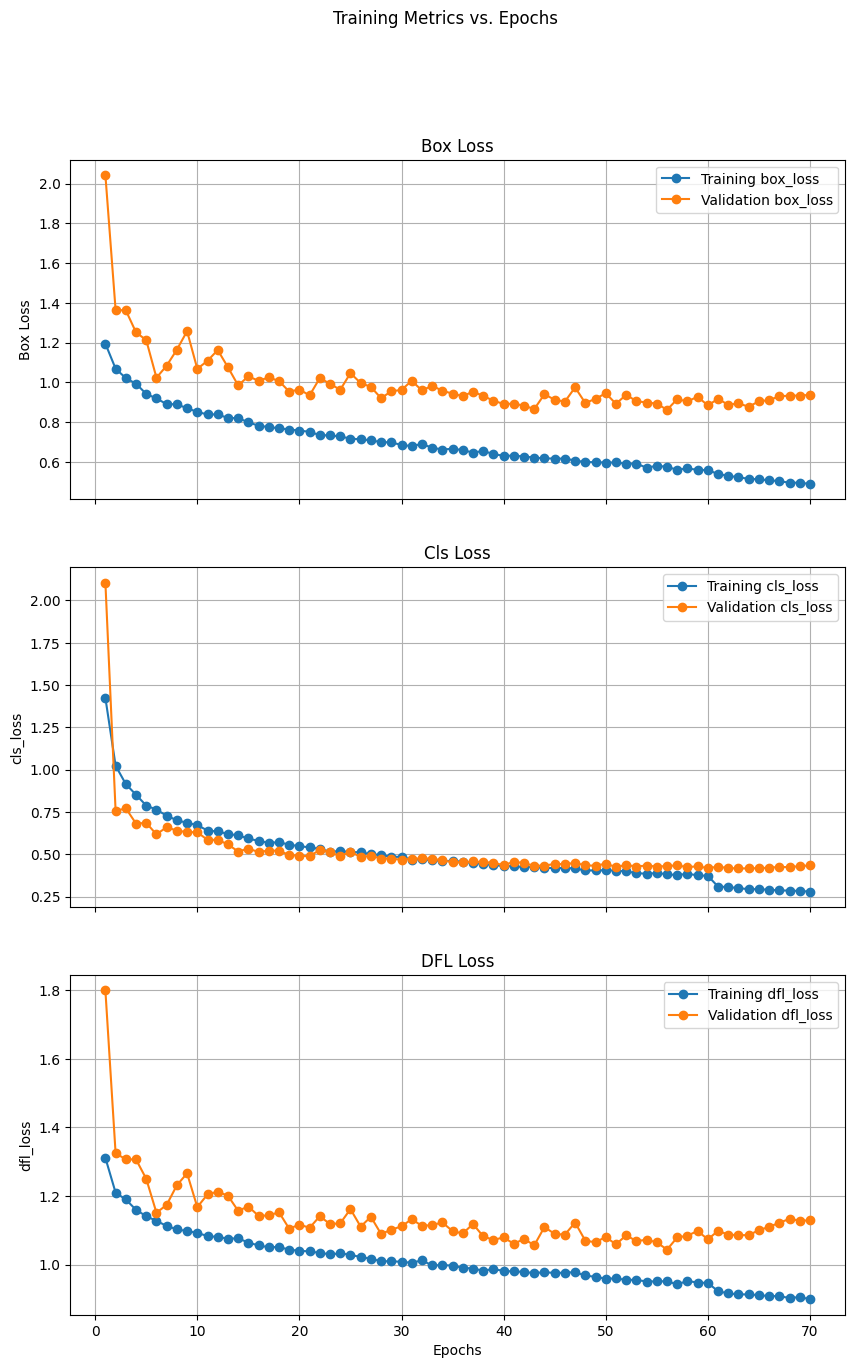

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov9e_ppe_css_70_epochs/val_batch1_labels.jpg


./runs/detect/yolov9e_ppe_css_70_epochs/val_batch1_pred.jpg


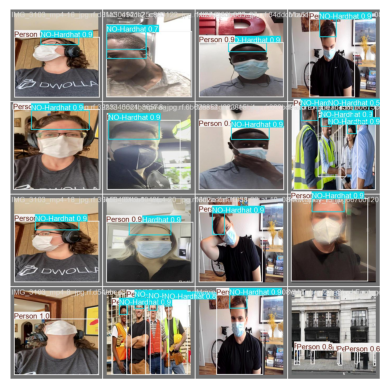

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

In [ ]:
import os
import zipfile

# Define the directory to be zipped and the output zip file name
directory_to_zip = './runs/detect/yolov9e_ppe_css_70_epochs'
output_zip_file = './runs/detect/results.zip'

# Create a ZipFile object
with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(directory_to_zip):
        for filename in filenames:
            # Create a complete path of file to be zipped
            file_to_zip = os.path.join(dirpath, filename)
            # Adding file to zip
            zipf.write(file_to_zip, arcname=os.path.relpath(file_to_zip, directory_to_zip))

print("Files zipped successfully!")

Files zipped successfully!


# Conclusions

- So now the model is trained and we have customized Yolo to detect PPE.
- In my [next notebook](https://www.kaggle.com/hinepo/yolov9-inference-for-red-zone-application) I will use this model to make inference on a video, and combine the PPE detection with a Red Zone application.
- **<font color='orange'>Upvote if you liked it!</font>**